<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# HMS - Harmful Brain Activity Classification with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

> The objective of this competition is to classify seizures and other patterns of harmful brain activity in critically ill patients

This notebook guides you through the process of training and inferring a Deep Learning model, specifically EfficientNetV2, using KerasCV on the competition dataset. Specificaclly, this notebook uses spectrogram of the eeg data to classify the patterns.

Fun fact: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. Utilizing KerasCV and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_core/announcement/).

In this notebook, you will learn:

* Loading the data efficiently using [`tf.data`](https://www.tensorflow.org/guide/data).
* Creating the model using KerasCV presets.
* Training the model.
* Inference and Submission on test data.

**Note**: For a more in-depth understanding of KerasCV, refer to the [KerasCV guides](https://keras.io/guides/keras_cv/).

# 🛠 | Install Libraries  

Since internet access is **disabled** during inference, we cannot install libraries in the usual `!pip install <lib_name>` manner. Instead, we need to install libraries from local files. In the following cell, we will install libraries from our local files. The installation code stays very similar - we just use the `filepath` instead of the `filename` of the library. So now the code is `!pip install <local_filepath>`. 

> The `filepath` of these local libraries look quite complicated, but don't be intimidated! Also `--no-deps` argument ensures that we are not installing any additional libraries.

In [9]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

# 📚 | Import Libraries 

In [16]:
from tqdm.notebook import tqdm


In [17]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt 

## Library Versions

In [18]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasCV: 0.8.2


# ⚙️ | Configuration

In [19]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 13 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [20]:
keras.utils.set_random_seed(CFG.seed)

# 📁 | Dataset Path 

In [21]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

# 📖 | Meta Data 

In [22]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec2_path,class_name,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/train_spectrograms/35373...,Seizure,0


,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec2_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...,/tmp/dataset/hms-hbac/test_spectrograms/853520...


## Convert `.parquet` to `.npy`

To facilitate easier data loading, we will convert the EEG spectrograms from `parquet` to `npy` format. This process involves saving the spectrogram data, and since the content of the files remains the same, no significant changes are made. 

> It's worth noting that the `time` column is excluded, as it is not part of the spectrogram.

In [23]:
# Define a function to process a single eeg_id
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids, total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)



  0%|          | 0/11138 [00:00<?, ?it/s]

  1%|          | 96/11138 [00:01<03:37, 50.66it/s]

  2%|▏         | 192/11138 [00:02<02:17, 79.42it/s]

  3%|▎         | 288/11138 [00:03<01:49, 99.16it/s]

  3%|▎         | 384/11138 [00:03<01:20, 132.80it/s]

  4%|▍         | 480/11138 [00:03<01:03, 167.08it/s]

  5%|▌         | 576/11138 [00:04<00:55, 188.82it/s]

  6%|▌         | 672/11138 [00:04<00:50, 209.23it/s]

  7%|▋         | 768/11138 [00:05<00:44, 232.69it/s]

  8%|▊         | 864/11138 [00:05<00:42, 239.92it/s]

  9%|▊         | 960/11138 [00:05<00:40, 249.91it/s]

  9%|▉         | 1056/11138 [00:06<00:39, 255.97it/s]

 10%|█         | 1152/11138 [00:06<00:38, 262.24it/s]

 11%|█         | 1248/11138 [00:06<00:37, 262.86it/s]

 12%|█▏        | 1344/11138 [00:07<00:36, 270.66it/s]

 13%|█▎        | 1440/11138 [00:07<00:35, 269.76it/s]

 14%|█▍        | 1536/11138 [00:07<00:34, 277.33it/s]

 15%|█▍        | 1632/11138 [00:08<00:34, 277.60it/s]

 16%|█▌        | 1728/11138 [00:08

# 🍚 | DataLoader

This DataLoader first reads `npy` spectrogram files and extracts labeled subsamples using specified `offset` values. Then, it converts the spectrogram data into `log spectrogram` and applies the popular signal augmentation `MixUp`.

> Note that, we are converting the mono channel signal to a 3-channel signal for using "ImageNet" weights of pretrained model.

In [24]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

# 🔪 | Data Split

In the following code snippet, the data is divided into `5` folds. Note that, the `groups` argument is used to prevent any overlap of patients between the training and validation sets, thus avoiding potential **data leakage** issues. Additionally, each split is stratified based on the `class_label`, ensuring a uniform distribution of class labels in each fold.

In [25]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Build Train & Valid Dataset

Only first sample for each `spectrogram_id` is used in order to keep the dataset size managable. Feel free to train on full data.

In [26]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


## Dataset Check

Let's visualize some samples from the dataset.

Exception ignored in: <function tqdm.__del__ at 0x7d4ab29fb490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


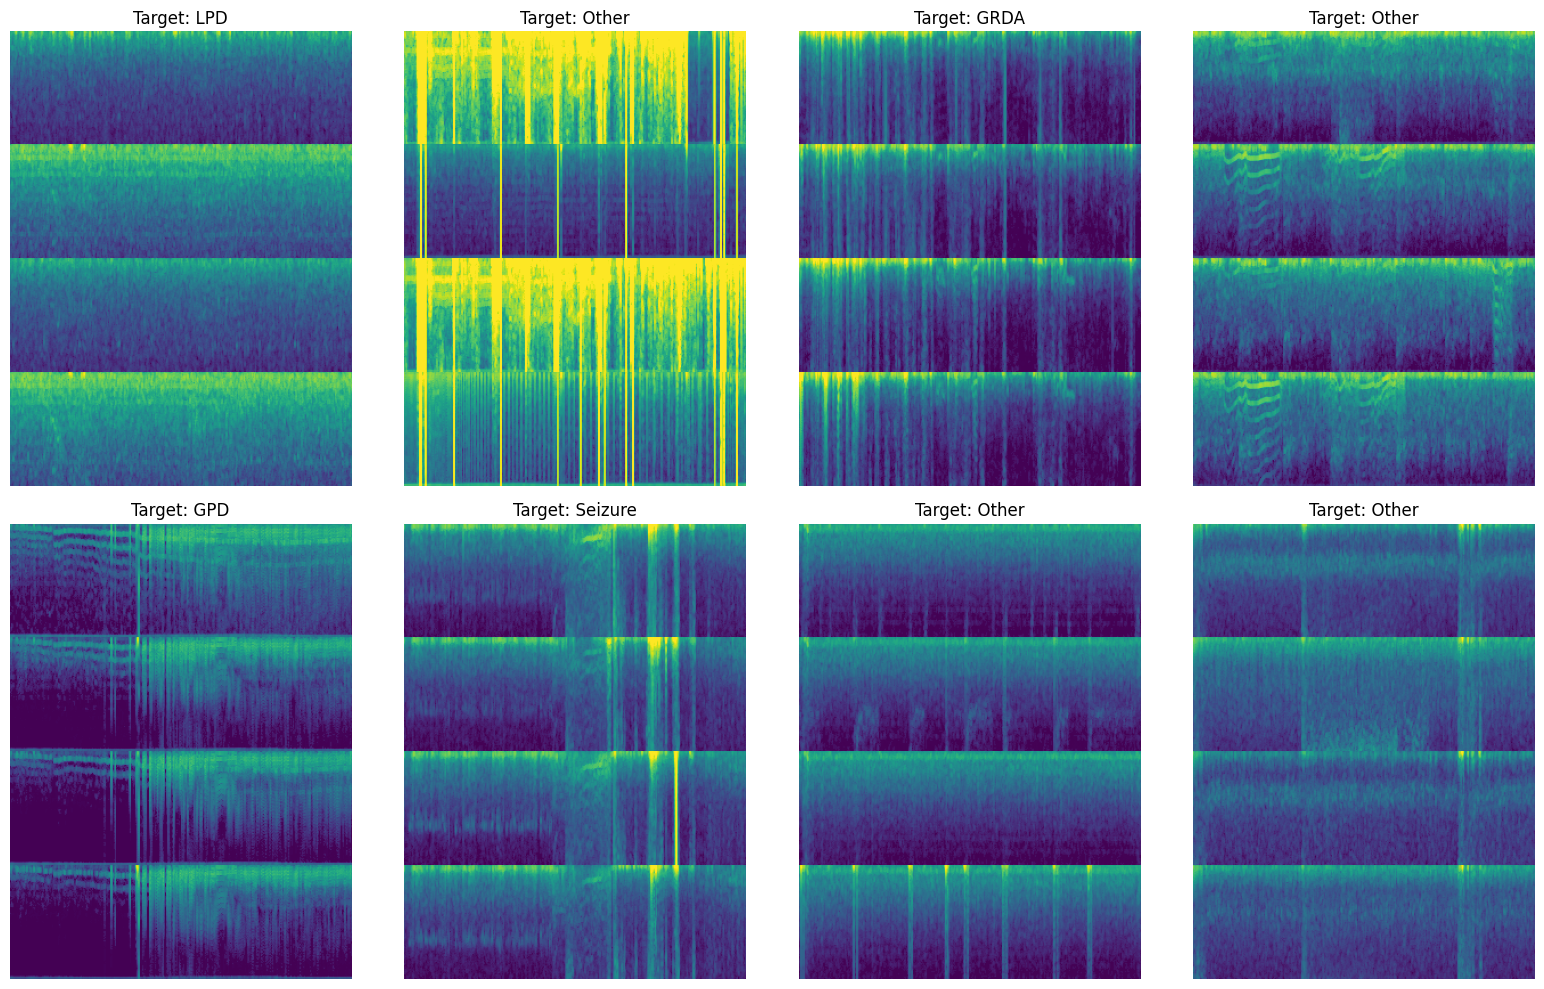

In [27]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    img -= img.min()
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Using ResNet and other models

In [21]:
from tensorflow.keras import layers, models

def identity_block(input_tensor, filters):
    f1, f2, f3 = filters

    x = layers.Conv2D(f1, (1, 1))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f3, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x

def conv_block(input_tensor, filters, strides=(2, 2)):
    f1, f2, f3 = filters

    x = layers.Conv2D(f1, (1, 1), strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f3, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(f3, (1, 1), strides=strides)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet50(input_shape, num_classes):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(input_tensor, x)
    return model

# Example of creating the ResNet50 model
input_shape = (224, 224, 3)
num_classes = 6  # Set according to your dataset
resnet50_model = build_resnet50(input_shape, num_classes)
resnet50_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │   9,472 │ input_layer_2[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │     256 │ conv2d_53[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_49 (ReLU)     │ (None, 112, 112,  │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 55, 55,    │       0 │ re_lu_49[0][0]       │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 55, 55,    │   4,160 │ max_pooling2d_1[0][… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │     256 │ conv2d_54[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_50 (ReLU)     │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 55, 55,    │  36,928 │ re_lu_50[0][0]       │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │     256 │ conv2d_55[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_51 (ReLU)     │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 55, 55,    │  16,640 │ re_lu_51[0][0]       │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 55, 55,    │  16,640 │ max_pooling2d_1[0][… │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │   1,024 │ conv2d_56[0][0]      │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │   1,024 │ conv2d_57[0][0]      │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_16 (Add)        │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 256)              │         │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_52 (ReLU)     │ (None, 55, 55,    │       0 │ add_16[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

# 🔍 | Loss & Metric

The evaluation metric in this competition is **KL Divergence**, defined as,

$$
D_{\text{KL}}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- $P$ is the true distribution.
- $Q$ is the predicted distribution.

Interestingly, as KL Divergence is differentiable, we can directly use it as our loss function. Thus, we don't need to use a third-party metric like **Accuracy** to evaluate our model. Therefore, `valid_loss` can stand alone as an indicator for our evaluation. In keras, we already have impelementation for KL Divergence loss so we only need to import it.

In [28]:
LOSS = keras.losses.KLDivergence()

# 🤖 | Modeling

This notebook uses the `EfficientNetV2 B2` from KerasCV's collection of pretrained models. To explore other models, simply modify the `preset` in the `CFG` (config). Check the [KerasCV website](https://keras.io/api/keras_cv/models/tasks/image_classifier/) for a list of available pretrained models.

In [26]:
# Build Classifier
#model = keras_cv.models.ImageClassifier.from_preset(
 #   CFG.preset, num_classes=CFG.num_classes
#)

# Compile the model  
resnet50_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
resnet50_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │   9,472 │ input_layer_2[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │     256 │ conv2d_53[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_49 (ReLU)     │ (None, 112, 112,  │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 55, 55,    │       0 │ re_lu_49[0][0]       │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 55, 55,    │   4,160 │ max_pooling2d_1[0][… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │     256 │ conv2d_54[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_50 (ReLU)     │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 55, 55,    │  36,928 │ re_lu_50[0][0]       │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │     256 │ conv2d_55[0][0]      │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_51 (ReLU)     │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 55, 55,    │  16,640 │ re_lu_51[0][0]       │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 55, 55,    │  16,640 │ max_pooling2d_1[0][… │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │   1,024 │ conv2d_56[0][0]      │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │   1,024 │ conv2d_57[0][0]      │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_16 (Add)        │ (None, 55, 55,    │       0 │ batch_normalization… │
│                     │ 256)              │         │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_52 (ReLU)     │ (None, 55, 55,    │       0 │ add_16[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

# ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [29]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

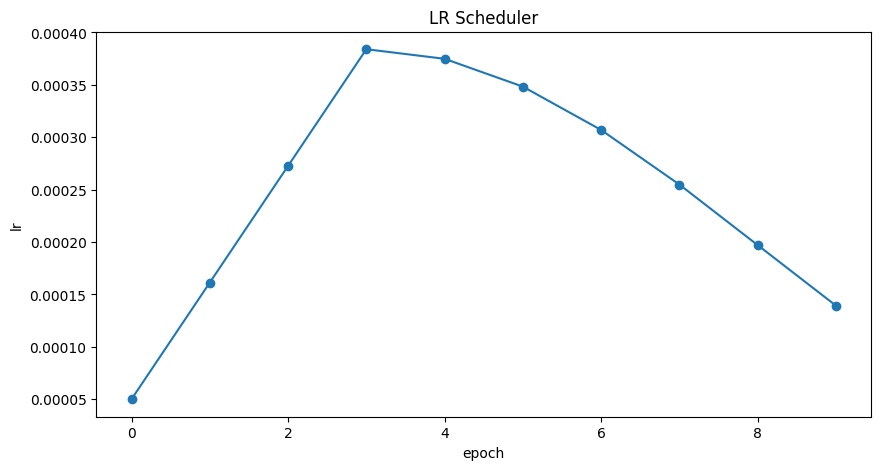

In [30]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

# 💾 | Model Checkpointing

In [31]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

# 🚂 | Training

In [30]:
history = resnet50_model.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13


2024-10-20 09:51:53.200937: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,1024,25,19]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,13,10]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-10-20 09:51:54.514808: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.314073155s
Trying algorithm eng0{} for conv (f32[64,1024,25,19]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,2048,13,10]{3,2,1,0}, f32[2048,1024,1,1]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operati

143/143 ━━━━━━━━━━━━━━━━━━━━ 166s 819ms/step - loss: 1.4561 - val_loss: 1.9845 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 648ms/step - loss: 1.3775 - val_loss: 2.7209 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 657ms/step - loss: 1.3262 - val_loss: 1.4900 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 648ms/step - loss: 1.2273 - val_loss: 2.5145 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 659ms/step - loss: 1.1578 - val_loss: 1.4053 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - loss: 1.0851 - val_loss: 1.6281 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 659ms/step - loss: 1.0450 - val_loss: 1.2573 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 648ms/step - loss: 0.9897 - val_loss: 1.2588 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 657ms/step - loss: 0.8936 - v

# Using deepXnet architecture

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the residual block with shape matching
def residual_block(x, filters):
    shortcut = x
    
    # Main path
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Adjust shortcut to match dimensions if necessary
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
    
    # Add shortcut (residual connection)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define the DeepXNet model
def DeepXNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # First block
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Second block with residual connection
    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Third block with residual connection
    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)
    
    # Fourth block
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model definition
    model = Model(inputs, outputs)
    return model

# Set input shape to match your dataset
input_shape = (400, 300, 3)
num_classes = 6  # Set according to your dataset
deepXnet = DeepXNet(input_shape, num_classes)

# Compile the model  
deepXnet .compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
deepXnet.summary()



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 400, 300,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_128 (Conv2D) │ (None, 400, 300,  │     896 │ input_layer_6[0][0]  │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 400, 300,  │     128 │ conv2d_128[0][0]     │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_19       │ (None, 400, 300,  │       0 │ batch_normalization… │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_129 (Conv2D) │ (None, 400, 300,  │  18,496 │ activation_19[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 400, 300,  │     256 │ conv2d_129[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_20       │ (None, 400, 300,  │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_12    │ (None, 200, 150,  │       0 │ activation_20[0][0]  │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_12          │ (None, 200, 150,  │       0 │ max_pooling2d_12[0]… │
│ (Dropout)           │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_130 (Conv2D) │ (None, 200, 150,  │  36,928 │ dropout_12[0][0]     │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 200, 150,  │     256 │ conv2d_130[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_21       │ (None, 200, 150,  │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_131 (Conv2D) │ (None, 200, 150,  │  36,928 │ activation_21[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 200, 150,  │     256 │ conv2d_131[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_38 (Add)        │ (None, 200, 150,  │       0 │ batch_normalization… │
│                     │ 64)               │         │ dropout_12[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_22       │ (None, 200, 150,  │       0 │ add_38[0][0]         │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_13    │ (None, 100, 75,   │       0 │ activation_22[0][0]

 Total params: 755,782 (2.88 MB)

 Trainable params: 754,310 (2.88 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [39]:
history = deepXnet.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 513ms/step - loss: 1.5543 - val_loss: 1.7782 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 484ms/step - loss: 1.3413 - val_loss: 1.7653 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - loss: 1.2991 - val_loss: 1.7461 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - loss: 1.2072 - val_loss: 1.4780 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 484ms/step - loss: 1.1889 - val_loss: 1.4241 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - loss: 1.1417 - val_loss: 2.8947 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - loss: 1.1866 - val_loss: 1.2862 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - loss: 1.1570 - val_loss: 1.3814 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 485ms/step - loss: 1

# Attention CNN

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Multiply, Add, Input, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

def attention_block(x):
    attention = GlobalAveragePooling2D()(x)
    attention = Dense(x.shape[-1], activation='relu')(attention)
    attention = Dense(x.shape[-1], activation='sigmoid')(attention)
    return Multiply()([x, attention])

def HybridCNN_Attention(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv Block
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Conv Block 1
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Conv Block 2
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Conv Block 3
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model definition
    model = Model(inputs, outputs)
    return model

# Set input shape to match your dataset
input_shape = (200, 150, 3)

num_classes = 6  # Set according to your dataset
attcnn = HybridCNN_Attention(input_shape, num_classes)
# Compile the model  
attcnn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
attcnn.summary()

E0000 00:00:1729422077.965479      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 150,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 150,  │   1,792 │ input_layer[0][0]    │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 200, 150,  │     256 │ conv2d[0][0]         │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 200, 150,  │       0 │ batch_normalization… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 200, 150,  │  73,856 │ activation[0][0]     │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 200, 150,  │     512 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_1        │ (None, 200, 150,  │       0 │ batch_normalization… │
│ (Activation)        │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 128)       │       0 │ activation_1[0][0]   │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 128)       │  16,512 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  16,512 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply (Multiply) │ (None, 200, 150,  │       0 │ activation_1[0][0],  │
│                     │ 128)              │         │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 100, 75,   │       0 │ multiply[0][0]       │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 75,   │ 295,168 │ max_pooling2d[0][0]  │
│                     │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 100, 75,   │   1,024 │ conv2d_2[0][0]       │
│ (BatchNormalizatio… │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_2        │ (None, 100, 75,   │       0 │ batch_normalization… │
│ (Activation)        │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 256)       │       0 │ activation_2[0][0]   │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  65,792 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │  65,792 │ dense_2[0][0]      

 Total params: 2,776,198 (10.59 MB)

 Trainable params: 2,774,278 (10.58 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [33]:
history = attcnn.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose,
    batch_size=16
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 118s 738ms/step - loss: 1.3765 - val_loss: 1.7109 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 622ms/step - loss: 1.2544 - val_loss: 1.6211 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 625ms/step - loss: 1.2521 - val_loss: 1.5695 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - loss: 1.1612 - val_loss: 1.6349 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - loss: 1.1437 - val_loss: 1.5457 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 622ms/step - loss: 1.0926 - val_loss: 1.5531 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - loss: 1.1098 - val_loss: 1.6994 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 623ms/step - loss: 1.0870 - val_loss: 1.6407 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - loss: 

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Multiply, Add, Input, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

def attention_block(x):
    """Attention block to enhance feature maps."""
    attention = GlobalAveragePooling2D()(x)
    attention = Dense(x.shape[-1], activation='relu')(attention)
    attention = Dense(x.shape[-1], activation='sigmoid')(attention)
    return Multiply()([x, attention])

def EfficientNetV2B2_Attention(input_shape, num_classes):
    """Hybrid CNN architecture using EfficientNetV2B2 backbone with attention blocks."""
    
    # Load EfficientNetV2B2 as the backbone
    base_model = tf.keras.applications.EfficientNetV2B2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False

    # Input layer
    inputs = Input(shape=input_shape)

    # Base model (EfficientNetV2B2)
    x = base_model(inputs, training=False)

    # Attention on the backbone output
    x = attention_block(x)

    # Further convolutional blocks (optional)
    # Conv Block 1
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Conv Block 2
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Model definition
    model = Model(inputs, outputs)
    return model

# Set input shape to match your dataset
input_shape = (400,300, 3)

num_classes = 6  # Set according to your dataset
Eff_improved = EfficientNetV2B2_Attention(input_shape, num_classes)

# Compile the model  
Eff_improved.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)


# Model Summary
Eff_improved.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 400, 300,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ efficientnetv2-b2   │ (None, 13, 10,    │ 8,769,… │ input_layer_9[0][0]  │
│ (Functional)        │ 1408)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 1408)      │       0 │ efficientnetv2-b2[0… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_32 (Dense)    │ (None, 1408)      │ 1,983,… │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_33 (Dense)    │ (None, 1408)      │ 1,983,… │ dense_32[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_12         │ (None, 13, 10,    │       0 │ efficientnetv2-b2[0… │
│ (Multiply)          │ 1408)             │         │ dense_33[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 13, 10,    │ 1,622,… │ multiply_12[0][0]    │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 13, 10,    │     512 │ conv2d_10[0][0]      │
│ (BatchNormalizatio… │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_10       │ (None, 13, 10,    │       0 │ batch_normalization… │
│ (Activation)        │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 128)       │       0 │ activation_10[0][0]  │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │  16,512 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │  16,512 │ dense_34[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_13         │ (None, 13, 10,    │       0 │ activation_10[0][0], │
│ (Multiply)          │ 128)              │         │ dense_35[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_9     │ (None, 6, 5, 128) │       0 │ multiply_13[0][0]    │
│ (MaxPooling2D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 6, 5, 256) │ 295,168 │ max_pooling2d_9[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 6, 5, 256) │   1,024 │ conv2d_11[0][0]      │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_11       │ (None, 6, 5, 256) │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 256)       │       0 │ activation_11[0][0]  │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼────────────────────

 Total params: 15,089,892 (57.56 MB)

 Trainable params: 6,319,750 (24.11 MB)

 Non-trainable params: 8,770,142 (33.46 MB)

In [43]:
history = Eff_improved.fit(
    train_ds, 
    epochs=20,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - loss: 1.4193 - val_loss: 1.6235 - learning_rate: 5.0000e-05
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - loss: 1.3177 - val_loss: 1.4510 - learning_rate: 1.6133e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - loss: 1.3528 - val_loss: 1.4219 - learning_rate: 2.7267e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - loss: 1.2676 - val_loss: 1.3302 - learning_rate: 3.8400e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step - loss: 1.2542 - val_loss: 1.3776 - learning_rate: 3.7485e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 105ms/step - loss: 1.2191 - val_loss: 1.3107 - learning_rate: 3.4829e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 1.2466 - val_loss: 1.3013 - learning_rate: 3.0692e-04
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 1.2257 - val_loss: 1.3307 - learning_rate: 2.5479e-04
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 1

In [44]:
# Build Classifier
mobilenet_V3 = keras_cv.models.ImageClassifier.from_preset(
    "mobilenet_v3_large", num_classes=CFG.num_classes
)

# Compile the model  
mobilenet_V3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
mobilenet_V3.summary()

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, None, None, 3)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ mobile_net_v3_backbone          │ (None, None, None, 960)   │  2,996,352 │
│ (MobileNetV3Backbone)           │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ avg_pool                        │ (None, 960)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ predictions (Dense)             │ (None, 6)                 │      5,766 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 3,002,118 (11.45 MB)

 Trainable params: 2,977,718 (11.36 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [45]:
history = mobilenet_V3.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 300ms/step - loss: 1.4944 - val_loss: 1.7595 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - loss: 1.2741 - val_loss: 1.7404 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - loss: 1.1801 - val_loss: 1.7274 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - loss: 1.0486 - val_loss: 1.7084 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - loss: 1.0025 - val_loss: 1.6940 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - loss: 0.9448 - val_loss: 1.6769 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 183ms/step - loss: 0.9141 - val_loss: 1.6572 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 184ms/step - loss: 0.8595 - val_loss: 1.6378 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - loss: 0

In [46]:
# Build Classifier
effnet_V2 = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b2_imagenet", num_classes=CFG.num_classes
)

# Compile the model  
effnet_V2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS)

# Model Sumamry
effnet_V2.summary()

Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, None, None, 3)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None, 1408)  │  8,769,374 │
│ (EfficientNetV2Backbone)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ avg_pool                        │ (None, 1408)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ predictions (Dense)             │ (None, 6)                 │      8,454 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [47]:
history =effnet_V2.fit(
    train_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    steps_per_epoch=len(train_df)//CFG.batch_size,
    validation_data=valid_ds, 
    verbose=CFG.verbose
)

Epoch 1/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 393ms/step - loss: 1.4264 - val_loss: 1.3638 - learning_rate: 5.0000e-05
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 260ms/step - loss: 1.1476 - val_loss: 1.0977 - learning_rate: 1.6133e-04
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - loss: 0.9893 - val_loss: 0.9984 - learning_rate: 2.7267e-04
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - loss: 0.8828 - val_loss: 0.9164 - learning_rate: 3.8400e-04
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - loss: 0.8368 - val_loss: 0.9030 - learning_rate: 3.7485e-04
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 260ms/step - loss: 0.7835 - val_loss: 0.8919 - learning_rate: 3.4829e-04
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 265ms/step - loss: 0.7311 - val_loss: 0.8617 - learning_rate: 3.0692e-04
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - loss: 0.6937 - val_loss: 0.8337 - learning_rate: 2.5479e-04
Epoch 9/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - loss: 

# 🧪 | Prediction

## Load Best Model

## Build Test Dataset

In [ ]:
test_paths = test_df.spec2_path.values
test_ds = build_dataset(test_paths, batch_size=min(CFG.batch_size, len(test_df)),
                         repeat=False, shuffle=False, cache=False, augment=False)

## Inference

In [ ]:
preds = model.predict(test_ds)

# 📩 | Submission

In [ ]:
pred_df = test_df[["eeg_id"]].copy()
target_cols = [x.lower()+'_vote' for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["eeg_id"]].copy()
sub_df = sub_df.merge(pred_df, on="eeg_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

# 📌 | Reference
* [HMS-HBAC: ResNet34d Baseline [Training]](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training) 
* [EfficientNetB2 Starter - [LB 0.57]](https://www.kaggle.com/code/cdeotte/efficientnetb2-starter-lb-0-57)